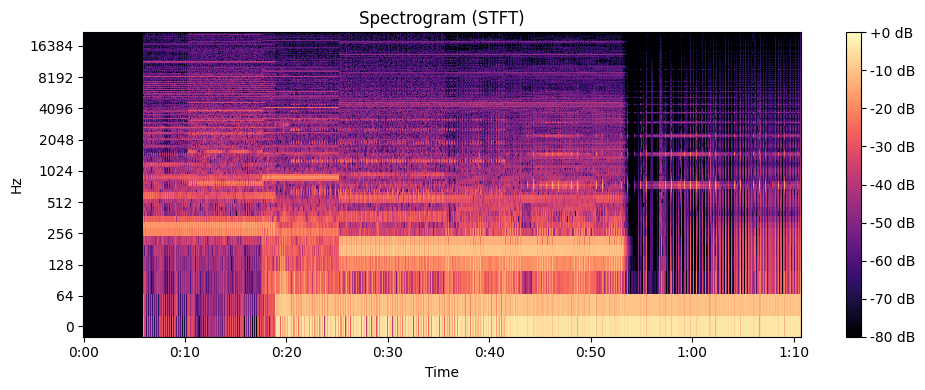

In [2]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

# load the audio file
filename = 'data/2025_07.wav'
signal, sr = librosa.load(filename, sr=None)

# STFT parameters
FFTwindow = 1000
hop = FFTwindow
window_fn = 'hann'

def compute_stft(sig):
    return np.abs(librosa.stft(sig, n_fft=FFTwindow, hop_length=hop, window=window_fn))

# create spectrogram
spectrogram = compute_stft(signal)

# show the spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.amplitude_to_db(spectrogram, ref=np.max),
                         sr=sr, hop_length=hop, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram (STFT)')
plt.tight_layout()
plt.show()
